In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

import statsmodels
from statsmodels.stats.anova import AnovaRM


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils, grid_utils, numpy_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
# computing the classifier confidence for correct vs. incorrect trials each task
# based on the predictions of multinomial classifier (from decode_multiclass.py)
# using bootstrap resampling to equate trial numbers/coordinates across tasks

# load results of multinomial classifier
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()

# specify some parameters
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)
n_tasks = 4;
n_subjects = 7
subjects = np.arange(1,8)

# load labels for each trial
lab = dict()
for ss in subjects:

    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)


grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 




In [4]:
n_boot_samp = 50; rndseed = 546466;

#### Bin trials based on distance to relevant boundary

In [7]:
n_coord_bins = 12;
coord_bin_edges = np.linspace(-0.701, 0.701, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = bin_centers.round(2)

0
1
2
3
4
5
6


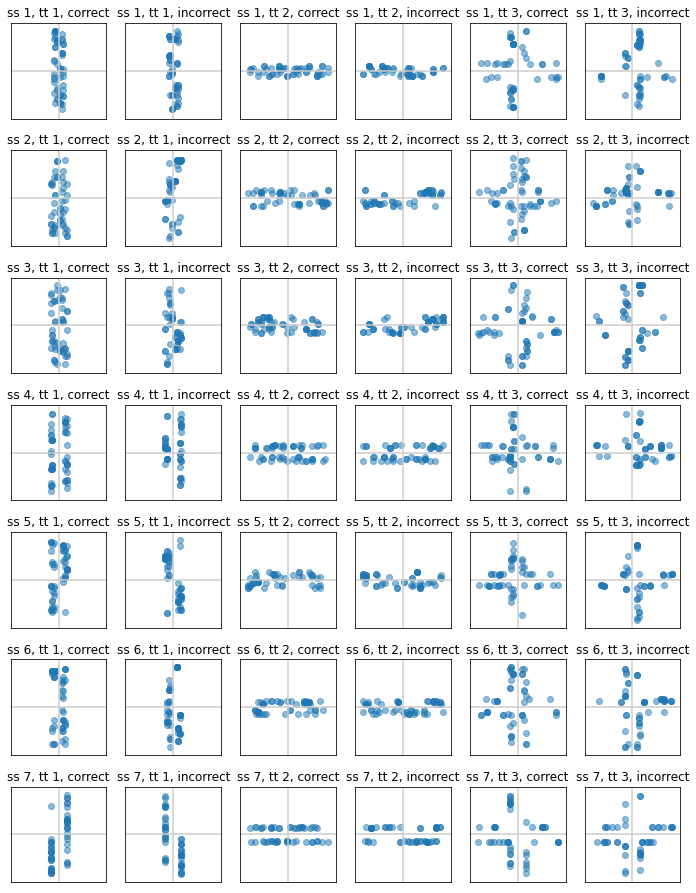

In [10]:

np.random.seed(rndseed)

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)

    for ti, tt in enumerate([1,2,3]):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1

        ii = ti; # focusing on the task-relevant axis here

        # is it a hard trial?
        is_hard = ~is_main_grid

        quadrant = np.array(l['quadrant'])
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)])

        coord_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

        # coord_actual = pt_labs[:,ii].round(2)

        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))


        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]

        # print(len(inds1), len(inds2))

        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

#         print(un1, counts1)
#         print(un2, counts2)

#         print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]

        # print(bin_dist[bins_balance])

        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)

        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        # loop over correct/incorrect trials
        for ci, [inds,name] in enumerate(zip([inds1, inds2], \
                                            ['correct','incorrect'])):

            nt = len(inds)

            
            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                # print(bin_dist[bn])
                inds_bin = inds[coord_binned[inds]==bn]
                # print(np.unique(quadrant[inds_bin], return_counts=True))
            
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)
            # print(len(inds_resamp))

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))

            # print(np.unique(quadrant[inds_resamp], return_counts=True))
                            
            pi+=1
            plt.subplot(n_subjects, 6, pi)
            plt.plot(pt_labs[inds_resamp,0], \
                    pt_labs[inds_resamp,1],'o',alpha=0.5)
           
            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss %d, tt %d, %s'%(ss, tt, name))
            # plt.xlim([2.5-0.8, 2.5+0.8])
            # plt.ylim([2.5-0.8, 2.5+0.8])
            plt.xlim([-0.5,5.5])
            plt.ylim([-0.5, 5.5])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
#                

#### bin the trials based on distance from center

In [11]:
n_coord_bins = 12;
# coord_bin_edges = np.linspace(-0.701, 0.701, n_coord_bins+1)
coord_bin_edges = np.linspace(-3.4, 3.4, n_coord_bins+1)
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = bin_centers.round(2)
coord_bin_edges, bin_centers

(array([-3.4       , -2.83333333, -2.26666667, -1.7       , -1.13333333,
        -0.56666667,  0.        ,  0.56666667,  1.13333333,  1.7       ,
         2.26666667,  2.83333333,  3.4       ]),
 array([-3.11666667, -2.55      , -1.98333333, -1.41666667, -0.85      ,
        -0.28333333,  0.28333333,  0.85      ,  1.41666667,  1.98333333,
         2.55      ,  3.11666667]))

0
1
2
3
4
5
6


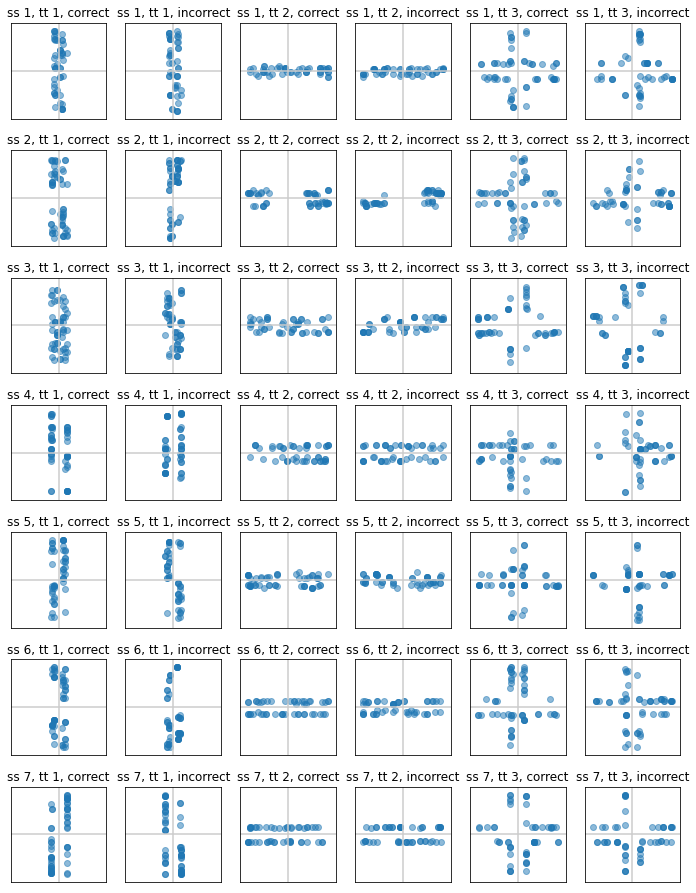

In [12]:

np.random.seed(rndseed)

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)

    # ti =2; tt =3;
    for ti, tt in enumerate([1,2,3]):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1

        ii = ti; # focusing on the task-relevant axis here

        # is it a hard trial?
        is_hard = ~is_main_grid


        categ_actual = np.array(l['categ_task%d'%(ii+1)])

        coord_actual = np.array(l['dist_from_center'])
        # coord_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

        # coord_actual = pt_labs[:,ii].round(2)

        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))


        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]

        # print(len(inds1), len(inds2))

        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        # print(un1, counts1)
        # print(un2, counts2)

        # print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]

        # print(bin_dist[bins_balance])

        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)

        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        # loop over correct/incorrect trials
        for ci, [inds,name] in enumerate(zip([inds1, inds2], \
                                            ['correct','incorrect'])):

            nt = len(inds)


            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)
            # print(len(inds_resamp))

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))


            pi+=1
            plt.subplot(n_subjects, 6, pi)
            plt.plot(pt_labs[inds_resamp,0], \
                    pt_labs[inds_resamp,1],'o',alpha=0.5)

            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss %d, tt %d, %s'%(ss, tt, name))
            # plt.xlim([2.5-0.8, 2.5+0.8])
            # plt.ylim([2.5-0.8, 2.5+0.8])
            plt.xlim([-0.5,5.5])
            plt.ylim([-0.5, 5.5])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
    #                

In [14]:
n_coord_bins = 6;
# coord_bin_edges = np.linspace(-0.701, 0.701, n_coord_bins+1)
coord_bin_edges = np.linspace(-3.4, 3.4, n_coord_bins+1)
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = bin_centers.round(2)
coord_bin_edges, bin_centers

(array([-3.4       , -2.26666667, -1.13333333,  0.        ,  1.13333333,
         2.26666667,  3.4       ]),
 array([-2.83333333, -1.7       , -0.56666667,  0.56666667,  1.7       ,
         2.83333333]))

0
[0 1 2 3 4 5] [12 23 36 20 12  3]
[0 1 2 3 4 5] [ 3  5 17 16 33 12]
[0 1 2 3 4 5] [ 5 26 21 33 27  4]
[0 1 2 3 4 5] [ 4 17 23 14 12  6]
[0 1 2 3 4 5] [12 34 12 16 47 10]
[0 1 2 3 4 5] [ 1 21 16  2 18  3]
1
[0 1 2 3 4 5] [ 9 26 11 43 27  7]
[0 1 2 3 4 5] [ 5 21 24  2 12  5]
[0 1 2 3 4 5] [ 6 25 12 37 35  3]
[0 1 2 4 5] [ 5 19 29 15  6]
[0 1 2 3 4 5] [11 33 16 23 34  7]
[0 1 2 3 4 5] [ 1 15 20  5 21  6]
2
[0 1 2 3 4 5] [ 3 26 22 32 38  8]
[0 1 2 3 4] [ 6 18 21 10  8]
[0 1 2 3 4 5] [ 4 36 25 26 43  8]
[0 1 2 3 4 5] [ 1  7 23  3 11  5]
[0 1 2 3 4 5] [ 9 38  5 29 44  9]
[0 1 2 4 5] [ 3 20 21 11  3]
3
[0 1 2 3 4 5] [ 8 42 28 23 27  2]
[0 1 2 3 4 5] [ 1  1 16 16 22  6]
[0 1 2 3 4 5] [ 3 29 30 34 31  5]
[0 1 2 3 4 5] [ 2 19 13 10 10  6]
[0 1 2 3 4 5] [10 31 18 31 32  9]
[0 1 2 3 4 5] [ 4 14 19  6 15  3]
4
[0 1 2 3 4 5] [13 39 23 27 18  1]
[0 1 2 3 4 5] [ 1 12  8 17 25  8]
[0 1 2 3 4 5] [ 7 15 13 36 40  6]
[0 1 2 3 4 5] [ 4 27 30  3  3  8]
[0 1 2 3 4 5] [ 8 29  9 36 44  3]
[0 1 2 3 4 5] [ 7 2

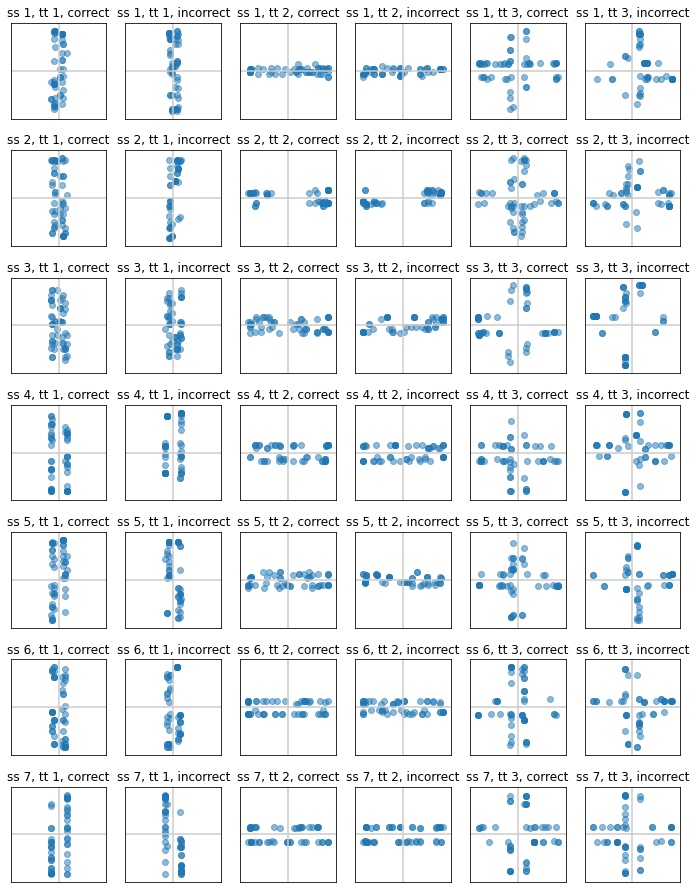

In [15]:

np.random.seed(rndseed)

plt.figure(figsize=(12,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)

    # ti =2; tt =3;
    for ti, tt in enumerate([1,2,3]):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1

        ii = ti; # focusing on the task-relevant axis here

        # is it a hard trial?
        is_hard = ~is_main_grid


        categ_actual = np.array(l['categ_task%d'%(ii+1)])

        coord_actual = np.array(l['dist_from_center'])
        # coord_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

        # coord_actual = pt_labs[:,ii].round(2)

        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))


        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]

        # print(len(inds1), len(inds2))

        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)

        # print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]

        # print(bin_dist[bins_balance])

        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)

        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        # loop over correct/incorrect trials
        for ci, [inds,name] in enumerate(zip([inds1, inds2], \
                                            ['correct','incorrect'])):

            nt = len(inds)


            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)
            # print(len(inds_resamp))

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))


            pi+=1
            plt.subplot(n_subjects, 6, pi)
            plt.plot(pt_labs[inds_resamp,0], \
                    pt_labs[inds_resamp,1],'o',alpha=0.5)

            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss %d, tt %d, %s'%(ss, tt, name))
            # plt.xlim([2.5-0.8, 2.5+0.8])
            # plt.ylim([2.5-0.8, 2.5+0.8])
            plt.xlim([-0.5,5.5])
            plt.ylim([-0.5, 5.5])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
    #                

In [16]:

bin_centers1 = coord1_bin_edges[0:-1]+(coord1_bin_edges[1]-coord1_bin_edges[0])/2
bin_dist1 = bin_centers1.round(2)
coord1_bin_edges, bin_centers1

(array([-3.4       , -2.26666667, -1.13333333,  0.        ,  1.13333333,
         2.26666667,  3.4       ]),
 array([-2.83333333, -1.7       , -0.56666667,  0.56666667,  1.7       ,
         2.83333333]))

In [17]:
n_coord1_bins = 6;
coord1_bin_edges = np.linspace(-3.4, 3.4, n_coord1_bins+1)
n_coord2_bins = 6;
coord2_bin_edges = np.linspace(-0.701, 0.701, n_coord2_bins+1)
bin_centers2 = coord2_bin_edges[0:-1]+(coord2_bin_edges[1]-coord2_bin_edges[0])/2
bin_dist2 = bin_centers2.round(2)
coord2_bin_edges, bin_centers2

(array([-0.701     , -0.46733333, -0.23366667,  0.        ,  0.23366667,
         0.46733333,  0.701     ]),
 array([-0.58416667, -0.3505    , -0.11683333,  0.11683333,  0.3505    ,
         0.58416667]))

In [30]:
def bin_vals(vals, bin_edges):
    
    assert(not np.any(np.isin(bin_edges, vals)))
    
    vals_binned = np.zeros(vals.shape, dtype=int)-1
    n_bins = len(bin_edges)-1
    
    for cb in np.arange(n_bins):
        binds = (vals>=bin_edges[cb]) & (vals<=bin_edges[cb+1])
        assert(np.all(vals_binned[binds]==-1))
        vals_binned[binds] = cb
        
    return vals_binned

In [24]:
coord_binned = bin_vals(coord_actual, coord1_bin_edges)
coord_binned

array([5, 4, 0, 4, 1, 4, 2, 0, 3, 0, 0, 0, 3, 0, 3, 2, 2, 3, 5, 5, 5, 5,
       3, 0, 4, 5, 4, 2, 5, 0, 3, 1, 0, 0, 2, 5, 5, 5, 1, 5, 2, 0, 0, 4,
       1, 0, 5, 1, 5, 5, 1, 2, 4, 2, 0, 4, 5, 4, 5, 4, 3, 5, 5, 4, 3, 2,
       2, 2, 1, 0, 5, 0, 5, 0, 0, 3, 2, 0, 0, 0, 2, 0, 2, 5, 0, 0, 5, 5,
       0, 3, 1, 4, 5, 5, 5, 2, 0, 2, 5, 4, 5, 0, 2, 2, 0, 1, 5, 5, 2, 3,
       0, 0, 0, 0, 5, 5, 4, 3, 3, 0, 5, 0, 2, 4, 4, 2, 5, 3, 1, 0, 5, 2,
       1, 3, 0, 5, 0, 5, 4, 4, 1, 0, 5, 4, 5, 5, 5, 1, 3, 5, 5, 0, 3, 2,
       4, 5, 3, 0, 1, 0, 0, 0, 0, 3, 4, 2, 5, 5, 0, 0, 5, 0, 3, 5, 5, 0,
       5, 0, 1, 5, 5, 0, 4, 2, 2, 1, 4, 1, 2, 2, 2, 5, 1, 2, 5, 5, 0, 4,
       3, 5, 1, 3, 2, 4, 5, 3, 0, 1, 4, 3, 5, 0, 5, 1, 3, 0, 4, 2, 2, 4,
       5, 5, 0, 5, 0, 0, 5, 0, 2, 0, 1, 4, 5, 0, 0, 2, 5, 2, 5, 0, 0, 5,
       5, 1, 0, 4, 5, 5, 1, 5, 0, 1, 3, 0, 4, 0, 3, 5, 5, 5, 2, 3, 2, 5,
       4, 0, 3, 0, 5, 0, 0, 0, 0, 0, 5, 5, 0, 3, 3, 5, 1, 0, 5, 5, 0, 2,
       0, 2, 2, 2, 4, 0, 5, 5, 5, 0, 5, 3, 0, 0, 5,

In [29]:
coord_binned = bin_vals(coord_actual, coord2_bin_edges)
coord_binned

array([-1,  5, -1,  5,  0,  5, -1, -1, -1,  0, -1, -1, -1, -1,  5, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  5, -1,  5,  0, -1, -1,  5,  0, -1, -1,
        0, -1, -1, -1,  0, -1, -1, -1, -1,  5,  0, -1, -1,  0,  4, -1,  1,
       -1,  4, -1, -1,  4, -1,  4, -1,  4, -1, -1, -1,  4, -1, -1,  1,  1,
        1, -1,  4, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  4, -1, -1, -1,  1, -1, -1, -1,  4, -1, -1,
        1, -1, -1,  1, -1, -1,  1,  4,  1, -1, -1, -1, -1, -1,  4, -1, -1,
       -1, -1, -1,  1,  4,  4, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1,  4,  4,  1, -1, -1,  4, -1, -1, -1,  1, -1, -1, -1, -1, -1,
        1,  4,  4, -1, -1,  1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1,
       -1, -1,  4,  4, -1, -1, -1, -1,  1, -1, -1, -1,  4, -1,  1,  1,  4,
        1, -1,  1, -1,  4,  0,  0, -1, -1, -1,  5, -1, -1,  0, -1, -1,  5,
       -1,  5, -1,  0,  5, -1, -1, -1, -1,  0, -1, -1,  5, -1, -1,  5, -1,
       -1, -1, -1, -1, -1

In [69]:
nbins1 = 6;
edges1 = np.linspace(-3.4, 3.4, nbins1+1)

nbins2 = 6;
edges2 = np.linspace(-0.701, 0.701, nbins2+1)

In [75]:
si = 0;ss = 1;
ti = 2;tt = 3;

l = lab[ss][lab[ss]['task']==tt]

pt_labs = np.array([l['ptx'], l['pty']]).T

is_main_grid = l['is_main_grid']==1

ii = ti; # focusing on the task-relevant axis here

# is it a hard trial?
is_hard = ~is_main_grid


categ_actual = np.array(l['categ_task%d'%(ii+1)])

d1 = np.array(l['dist_from_center'])
d1[categ_actual==1] = (-1)*d1[categ_actual==1]

d2 = np.array(l['dist_from_bound%d'%(ii+1)])
d2[categ_actual==1] = (-1)*d2[categ_actual==1]

b1 = numpy_utils.bin_vals(d1, edges1)
b2 = numpy_utils.bin_vals(d2, edges2)

assert(not np.any(b1[is_hard]==-1))
assert(not np.any(b2[is_hard]==-1))


In [78]:
d = np.array(l['dist_from_center'])
np.percentile(d,50)

2.5298221281347035

In [79]:
np.sum(d<2.5)

284

In [80]:
np.sum(d>=2.5)

292

In [71]:
# was the subject correct or incorrect?
correct = np.array(l['subject_correct'])

# inds1 = np.where(is_hard & correct)[0]
# inds2 = np.where(is_hard & ~correct)[0]
inds1 = is_hard & correct
inds2 = is_hard & ~correct

In [72]:
combs = np.array([b1[inds1], b2[inds1]]).T
np.unique(combs, axis=0)

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [2, 0],
       [2, 1],
       [3, 4],
       [3, 5],
       [4, 4],
       [4, 5],
       [5, 4],
       [5, 5]])

(-0.14500000000000002,
 5.245000000000001,
 -0.14500000000000002,
 5.245000000000001)

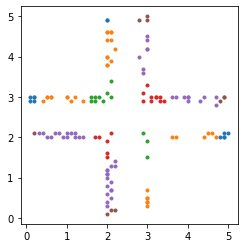

In [73]:
plt.figure()
for bi1 in range(nbins1):
    plt.plot(pt_labs[inds1 & (b1==bi1),0], pt_labs[inds1 & (b1==bi1),1], '.')
plt.axis('square')

(-0.14500000000000002,
 5.245000000000001,
 -0.14500000000000002,
 5.245000000000001)

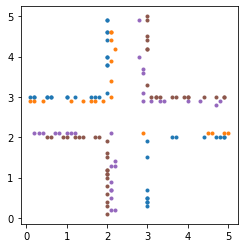

In [74]:
plt.figure()
for bi2 in range(nbins2):
    plt.plot(pt_labs[inds1 & (b2==bi2),0], pt_labs[inds1 & (b2==bi2),1], '.')
plt.axis('square')

In [38]:
inds1

array([  1,   3,   5,   9,  14,  24,  26,  30,  31,  34,  38,  44,  48,
        50,  52,  57,  59,  70,  91,  99, 102, 105, 108, 109, 110, 123,
       124, 128, 132, 139, 143, 154, 155, 158, 164, 172, 182, 185, 186,
       189, 191, 192, 193, 200, 203, 205, 207, 208, 213, 219, 236, 237,
       245, 250, 252, 254, 255, 258, 259, 263, 264, 269, 271, 277, 280,
       290, 293, 302, 303, 310, 312, 313, 317, 319, 330, 334, 347, 352,
       353, 356, 360, 361, 363, 367, 369, 370, 376, 382, 391, 393, 395,
       397, 400, 401, 408, 411, 413, 415, 427, 430, 433, 434, 440, 444,
       446, 450, 467, 468, 472, 475, 478, 479, 482, 497, 500, 507, 511,
       518, 519, 523, 526, 532, 537, 541, 548, 557, 559, 568, 572, 573,
       575])

In [39]:
inds2

array([  4,  27,  43,  47,  55,  63,  66,  67,  68,  76,  80,  90,  95,
       116, 122, 138, 140, 147, 153, 173, 178, 184, 187, 197, 216, 230,
       231, 235, 243, 248, 251, 305, 308, 321, 324, 325, 336, 342, 358,
       375, 389, 405, 417, 428, 439, 451, 470, 477, 480, 496, 506, 509,
       515, 522, 527, 533, 534, 558, 561, 562, 566])